In [1]:
import pandas as pd
import re
from unidecode import unidecode
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

pd.options.display.float_format = '{:,.0f}'.format

### Functions

In [2]:
def normalize_column_name(df):
    result = []
    for col in df.columns:
        col = re.sub('(\n|\t)', '', col) # replace \n and \t with ''
        col = col.lower() # lower
        col = re.sub(' ', '_', col) # repace ' ' with '_'
        col = unidecode(col) # remove accent
        
        result.append(col)
        
    df.columns = result
        
    return df

# 1. Load data

**Giá vàng SJC**

In [3]:
sjc = (
    pd.read_csv(r'D:\MINHTL\Tự học\0. Data Skillset\1. Python\6. Giá vàng\Data\gold_price\sjc.csv', usecols=['report_date','buy','sell','year','month','day'])
    .assign(report_date = lambda df_: pd.to_datetime(df_.report_date))
    .set_index('report_date', drop=True)
)
# sjc.report_date = pd.to_datetime(sjc.report_date)
# sjc = sjc.set_index('report_date', drop=True)
sjc

,buy,sell,year,month,day
report_date,,,,,
2017-01-01,"35,000,000","36,120,000",2017,1,1
2017-01-02,"35,000,000","36,120,000",2017,1,2
2017-01-03,"36,000,000","36,420,000",2017,1,3
2017-01-04,"36,220,000","36,540,000",2017,1,4
2017-01-05,"36,370,000","36,690,000",2017,1,5
...,...,...,...,...,...
2025-02-10,"88,300,000","91,300,000",2025,2,10
2025-02-11,"88,000,000","90,500,000",2025,2,11
2025-02-12,"86,700,000","90,200,000",2025,2,12


**Giá vàng thế giới**

In [4]:
xau = pd.read_csv(r'D:\MINHTL\Tự học\0. Data Skillset\1. Python\6. Giá vàng\Data\gold_price\xau.csv')
xau = normalize_column_name(xau)
xau.report_date = pd.to_datetime(xau.report_date)

xau = xau.set_index('report_date', drop=True)

**Bảng tổng**

In [5]:
df = (
    sjc.join(xau)
    .loc[:,  list(sjc.columns) + ['buy_rate']]
    .rename({'buy_rate': 'xau'}, axis=1)
    .assign(
        xau = lambda df: df.xau * 10
        ,buy = lambda df: df.buy / 10
        ,sell = lambda df: df.sell / 10
    )
)

df

,buy,sell,year,month,day,xau
report_date,,,,,,
2017-01-01,"3,500,000","3,612,000",2017,1,1,"3,611,500"
2017-01-02,"3,500,000","3,612,000",2017,1,2,"3,611,500"
2017-01-03,"3,600,000","3,642,000",2017,1,3,"3,625,500"
2017-01-04,"3,622,000","3,654,000",2017,1,4,"3,637,500"
2017-01-05,"3,637,000","3,669,000",2017,1,5,"3,649,500"
...,...,...,...,...,...,...
2025-02-10,"8,830,000","9,130,000",2025,2,10,"8,560,000"
2025-02-11,"8,800,000","9,050,000",2025,2,11,"9,005,000"
2025-02-12,"8,670,000","9,020,000",2025,2,12,"8,905,000"


### Variables

In [6]:
# lãi suất tiết kiệm
i = 0.05

def change_interest(n: float):
    global i
    i = n

# ngày chốt lãi
ngay_chotlai = '2025-01-01'

def change_ngay_chotlai(d: str):
    global ngay_chotlai
    ngay_chotlai = d
    
    global buy_price_chotlai
    buy_price_chotlai = df.loc[ngay_chotlai, 'buy']


# 2. Analysis

### Timeline giá vàng

<Axes: xlabel='report_date', ylabel='sell'>

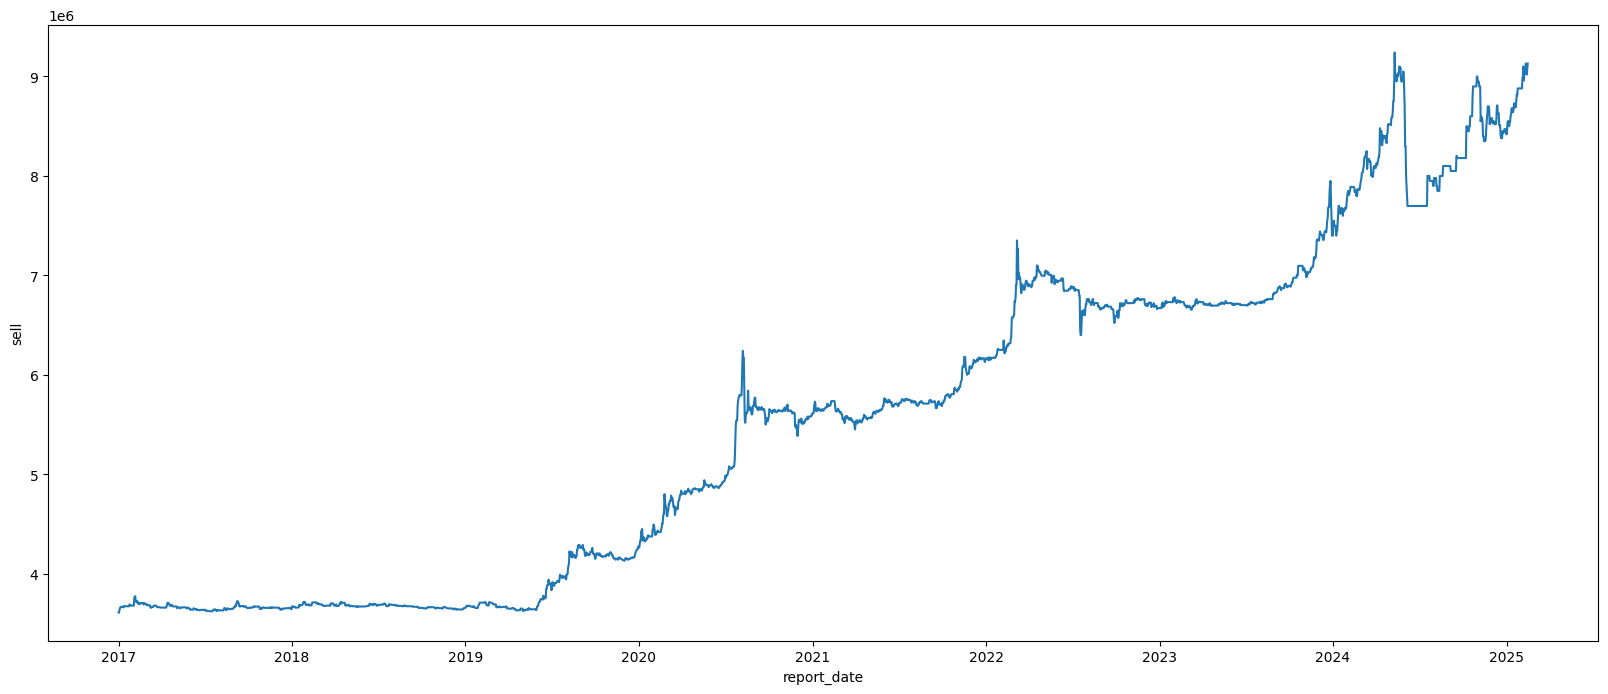

In [7]:
fig, ax = plt.subplots(figsize = (20,8))

sns.lineplot(
    data = df
    ,x = 'report_date'
    ,y = 'sell'
)

In [8]:
df.loc['2024-09-24',:]

buy     7,980,000
sell    8,180,000
year        2,024
month           9
day            24
xau     8,250,000
Name: 2024-09-24 00:00:00, dtype: float64

### Tạo bảng giá vốn `goc_df`

In [9]:
change_ngay_chotlai('2024-08-14')
change_interest(0.063)

# Điều kiện lọc để tạo bảng goc_df
goc_cond_1 = df.day == 15
goc_cond_2 = df.year.isin([2024])
goc_cond_3 = df.month.isin(list(range(1,7,1)))

goc_cond_total = goc_cond_1 & goc_cond_2 & goc_cond_3

# Goc_df
goc_df = (
    df.loc[goc_cond_total, [i for i in df.columns if i != 'xau']].
    assign(days_to_chotlai = lambda df_: (pd.to_datetime(pd.Series(ngay_chotlai, index = df_.index)) - df_.index).dt.days)
    .assign(saving_potential = lambda df_: df_.sell * ((1 + i)**(df_.days_to_chotlai // 365)) * (1 + df_.days_to_chotlai % 365 / 365 * i))
)

# ---------- Variable
# tổng giá gốc
goc_sum = goc_df.sell.sum()
# ngày bắt đầu mua
goc_start_date = goc_df.index.min().strftime('%Y-%m-%d')
# ngày kết thúc mua
goc_end_date = goc_df.index.max().strftime('%Y-%m-%d')


# -------- Tính PNL
# tổng giá trị bán
chotlai_sum = len(goc_df) * buy_price_chotlai 
chotlai_lai = chotlai_sum - goc_sum

tk_goc_va_lai = goc_df.saving_potential.sum()
diff_chotlai_tk = chotlai_sum - tk_goc_va_lai



# -------- Print result
print(f'{'Thời gian mua': <40} ---> {goc_start_date} - {goc_end_date}')
print(f'{'Tổng giá vốn mua': <40} ---> {goc_sum:,.0f} tổng {len(goc_df)} chỉ\n')
print(f'{'Ngày chốt lãi': <40} ---> {ngay_chotlai}')
print(f'{'Giá mua chốt lãi': <40} ---> {buy_price_chotlai:,.0f}/chỉ')
print('-'*30,'\n')
print(f'SO SÁNH PNL')
print(f'{'Tổng giá trị bán': <40} ---> {f'{len(goc_df) * buy_price_chotlai:,.0f}':>12} {'Lãi': >10} ---> {len(goc_df) * buy_price_chotlai - goc_sum:,.0f}')
print(f"{'Gốc + lãi nếu gửi TK với LS ' f'{i:.1%}': <40} ---> {f'{goc_df.saving_potential.sum():,.0f}':>12} {'Lãi':>10} ---> {goc_df.saving_potential.sum() - goc_sum:,.0f}")
print(f"{'Chênh lệch Bán vàng và Gửi TK: ':<40} ---> {f'{diff_chotlai_tk:,.0f}':>12}")
display(goc_df)

Thời gian mua                            ---> 2024-01-15 - 2024-06-15
Tổng giá vốn mua                         ---> 48,828,000 tổng 6 chỉ

Ngày chốt lãi                            ---> 2024-08-14
Giá mua chốt lãi                         ---> 7,800,000/chỉ
------------------------------ 

SO SÁNH PNL
Tổng giá trị bán                         --->   46,800,000        Lãi ---> -2,028,000
Gốc + lãi nếu gửi TK với LS 6.3%         --->   49,965,492        Lãi ---> 1,137,492
Chênh lệch Bán vàng và Gửi TK:           --->   -3,165,492


,buy,sell,year,month,day,days_to_chotlai,saving_potential
report_date,,,,,,,
2024-01-15,"7,400,000","7,650,000",2024,1,15,212,"7,929,927"
2024-02-15,"7,660,000","7,880,000",2024,2,15,181,"8,126,180"
2024-03-15,"7,970,000","8,170,000",2024,3,15,152,"8,384,345"
2024-04-15,"8,210,000","8,410,000",2024,4,15,121,"8,585,642"
2024-05-15,"8,770,000","9,020,000",2024,5,15,91,"9,161,676"
2024-06-15,"7,498,000","7,698,000",2024,6,15,60,"7,777,722"
